In [1]:
import os
os.chdir('/workspace')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch
from dataset.dataset_iter import data_formatting
warnings.filterwarnings('ignore')
from tqdm import tqdm

device="cuda"
d_type=torch.float32

In [2]:
import os

# 현재 위치
os.getcwd()

'/workspace'

# Modeling

In [3]:
def Mamba2Model():
    from model.mamba_stock import Mambamodeling
    pretrained_path="/workspace/weight/Mamba2"
    model=Mambamodeling(
            d_model=768,
            d_inermediate=2048,
            n_layer=8,
            layer="Mamba2",
            pretrained_path=pretrained_path
        ).to(device)
    model.eval()
    return model


def Mamba1Model():
    from model.mamba_stock import Mambamodeling
    pretrained_path="/workspace/weight/Mamba1"
    model=Mambamodeling(
            d_model=768,
            d_inermediate=2048,
            n_layer=8,
            layer="Mamba1",
            pretrained_path=pretrained_path
        ).to(device)
    model.eval()
    return model

def TransformerModel():
    from model.qwen_stock import QwenStock
    from transformers import AutoConfig
    
    model_name = "Qwen/Qwen2.5-Coder-0.5B-Instruct"
    
    qwenconfig=AutoConfig.from_pretrained(model_name,
                    intermediate_size= 2048,
                    max_position_embeddings= 128,
                    num_hidden_layers=8,
                    vocab_size= 5
                    )

    model=QwenStock(qwenconfig).from_pretrained("/workspace/weight/QWEN").to(device)
    return model

def predict(data,model,seq_length):
    stock_predictions=[]
    total= len(data)-seq_length
    
    for start_idx in tqdm(range(total), desc="Prediction", ncols=80, ascii=True):
        open=data.loc[data.index[start_idx], "Open"]
        input=data_formatting(data,start_idx,1,seq_length,d_type)
        with torch.no_grad():
            pred=model(input)[0,-1,:]
        price_pred=pred[3]*open/100
        stock_predictions.append(price_pred)
        if start_idx%200==0:
            torch.cuda.empty_cache()
    stock_predictions=torch.stack(stock_predictions, dim=0).cpu().numpy()
    data["predict"]=np.concatenate((np.zeros(seq_length), stock_predictions))
    return data


# Prediction

In [5]:
from backtesting.test import EURUSD,GOOG

data_path="/workspace/data/HBARUSDT_hour.csv"
stock=pd.read_csv(data_path)
#stock=EURUSD
#data_path="/workspace/data/BTCUSDT_15min.csv"
#df=pd.read_csv(data_path)
#filter_date = '2024-12-01'  # 원하는 날짜를 입력하세요
#stock = df[pd.to_datetime(df['date']) > pd.to_datetime(filter_date)]


#model=TransformerModel()
model=Mamba1Model()
predict(stock,model,127)

5
5
Mamba1 model is initialized.
Total parameters: 101.90M
Trainable parameters: 101.90M


Prediction: 100%|#########################| 45783/45783 [08:56<00:00, 85.39it/s]


,Unnamed: 0,open_time,Open,High,Low,Close,Volume,kline_close_time,quote_asset_volume,number_of_trades,base,quote,date,predict
0,0,1.569730e+12,0.03103,0.04400,0.03103,0.03958,5024848.8,1.569733e+12,2.018234e+05,856.0,2114335.8,8.505567e+04,2019-09-29,0.000000
1,1,1.569733e+12,0.03953,0.03991,0.03905,0.03924,2219095.5,1.569737e+12,8.757110e+04,338.0,698617.1,2.762996e+04,2019-09-29,0.000000
2,2,1.569737e+12,0.03922,0.03947,0.03755,0.03786,1791939.6,1.569740e+12,6.899727e+04,331.0,747785.5,2.881853e+04,2019-09-29,0.000000
3,3,1.569740e+12,0.03790,0.03816,0.03690,0.03766,1260399.9,1.569744e+12,4.719218e+04,244.0,543099.3,2.034389e+04,2019-09-29,0.000000
4,4,1.569744e+12,0.03785,0.03815,0.03662,0.03680,697492.2,1.569748e+12,2.609966e+04,154.0,337175.1,1.263616e+04,2019-09-29,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45905,45905,1.735117e+12,0.31031,0.32158,0.30974,0.32126,41188184.0,1.735121e+12,1.298938e+07,50931.0,24008615.0,7.573562e+06,2024-12-25,0.310329
45906,45906,1.735121e+12,0.32126,0.32581,0.31293,0.31401,70810405.0,1.735124e+12,2.266288e+07,105419.0,36583004.0,1.172913e+07,2024-12-25,0.320670
45907,45907,1.735124e+12,0.31400,0.31691,0.31112,0.31189,22296006.0,1.735128e+12,7.007405e+06,25234.0,9703389.0,3.050373e+06,2024-12-25,0.315642
45908,45908,1.735128e+12,0.31190,0.31419,0.30984,0.31269,23856148.0,1.735132e+12,7.441434e+06,30832.0,11280025.0,3.520249e+06,2024-12-25,0.314587


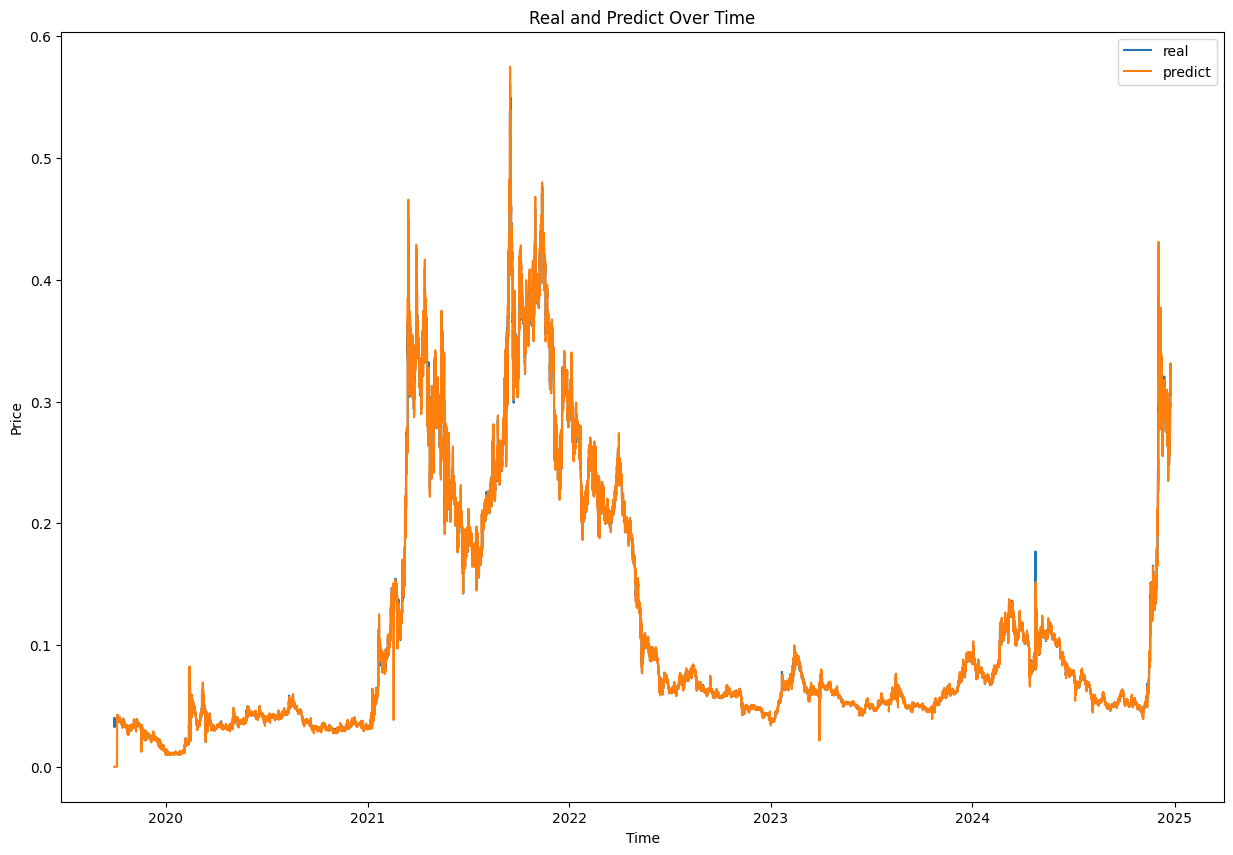

In [6]:
# 데이터를 DataFrame으로 변환
time= pd.to_datetime(stock['open_time'], unit='ms')
stock["time"]=time
stock.set_index('time', inplace=True)
#time=stock.index
# data2와 data1을 그래프로 그리기
plt.figure(figsize=(15, 10))  # 그래프 크기 설정 (선택적)
plt.plot(time, stock['Close'], label='real')
plt.plot(time, stock["predict"], label='predict')

# 그래프에 레이블과 범례 추가
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Real and Predict Over Time')
plt.legend()

# 그래프 표시
plt.show()

In [20]:
from backtesting import Strategy, Backtest
from backtesting.lib import SignalStrategy

class System(Strategy):
    def init(self):
        super().init()
        
    def next(self):
        price = self.data.Close[-1]         
        if (self.data.predict - price)/price > 0.001 and (self.data.predict - price)/price<0.2 and self.data.predict != 0:
            if not self.position.is_long:
                self.buy()      
        else:
            self.position.close()
       
            
backtest = Backtest(stock, System,
              cash=10000,
              commission=0.0002,
              exclusive_orders=True)


output=backtest.run()
#output.to_csv("/workspace/result/Mamba1_M.csv")
output

Start                     2019-09-29 04:00:00
End                       2024-12-25 13:00:00
Duration                   1914 days 09:00:00
Exposure Time [%]                   76.279678
Equity Final [$]                163472.417481
Equity Peak [$]                  265294.58543
Return [%]                        1534.724175
Buy & Hold Return [%]              687.038909
Return (Ann.) [%]                   70.326865
Volatility (Ann.) [%]              174.937193
Sharpe Ratio                         0.402012
Sortino Ratio                        1.288597
Calmar Ratio                         0.894677
Max. Drawdown [%]                  -78.605828
Avg. Drawdown [%]                   -6.758249
Max. Drawdown Duration     1139 days 00:00:00
Avg. Drawdown Duration       15 days 11:00:00
# Trades                                11436
Win Rate [%]                         58.69185
Best Trade [%]                      38.239149
Worst Trade [%]                    -25.282323
Avg. Trade [%]                    

In [21]:
from bokeh.plotting import figure, output_file, save

plot=backtest.plot()
save(plot)
plot

TypeError: Index.get_loc() got an unexpected keyword argument 'method'